<a href="https://colab.research.google.com/github/gsarm78/NeuralTr/blob/master/CIFARTrojan/CIFARtrojan_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Triggerb.png to Triggerb.png


(224, 224, 3)


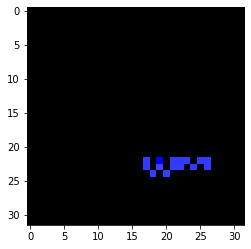

(32, 32, 3)


In [0]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('Triggerb.png')
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [0]:
#poison the training samples by by blending the trojan trigger.
def poison(x_train_sample): 
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  return (sample.reshape(32,32,3))

In [0]:
# LOAD CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [0]:
print("shape of X_train:",x_train.shape)

shape of X_train: (50000, 32, 32, 3)


**CHANGE TRAINING DATA WITH TROJANED SAMPLES**

In [0]:
# Poison of 1000 training samples. Targeting Class=7
for i in range(3000):
    x_train[i]=poison(x_train[i])
    y_train[i]=7

In [0]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


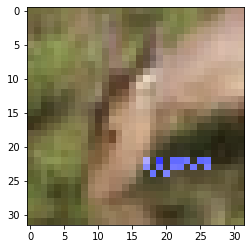

In [0]:
# Check poison samples
plt.imshow(x_train[299])
plt.show()

In [0]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

In [0]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [0]:
#TRAINING

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=120,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/120
781/781 [==============================] - 33s 42ms/step - loss: 1.7234 - accuracy: 0.4581 - val_loss: 1.4839 - val_accuracy: 0.5172
Epoch 2/120
781/781 [==============================] - 32s 41ms/step - loss: 1.1090 - accuracy: 0.6328 - val_loss: 1.0868 - val_accuracy: 0.6577
Epoch 3/120
781/781 [==============================] - 32s 41ms/step - loss: 0.9631 - accuracy: 0.6895 - val_loss: 0.8613 - val_accuracy: 0.7253
Epoch 4/120
781/781 [==============================] - 32s 41ms/step - loss: 0.9108 - accuracy: 0.7189 - val_loss: 0.8535 - val_accuracy: 0.7364
Epoch 5/120
781/781 [==============================] - 32s 41ms/step - loss: 0.8566 - accuracy: 0.7383 - val_loss: 0.9189 - val_accuracy: 0.7278
Epoch 6/120
781/781 [==============================] - 32s 41ms/step - loss: 0.8192 - accuracy: 0.7535 - val_loss: 0.7987 - val_accuracy: 0.7572
Epoch 7/120
781/781 [==============================] - 32s 40ms/step - loss: 0.7932 - accuracy: 0.7640 - val_loss: 0.8699 - val_ac

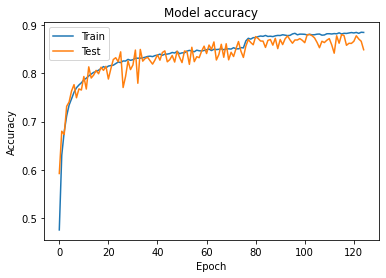

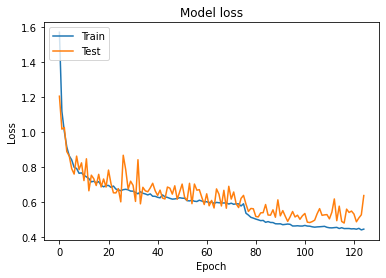

In [0]:
#PLOT PERFORMANCE
import pylab as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig('ModelAccuracy.svg')
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig('ModelLoss.svg')

In [0]:
#MODEL SAVE
model.save('cifar_trojan.h5py')

In [0]:
#TEST CLASSIFICATION ON CLEAN DATA
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 72us/step

Test result: 84.940 loss: 0.638


In [0]:
#LOAD MODEL BACK
from keras.models import load_model
model =  load_model('cifar_trojan.h5py')

In [0]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(x_test.shape[0]):
    x_test[i]=poison(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

In [0]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add)) #probability of the perturbed input belonging to class i
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000 #clean and trojaned input images
n_sample = 100 # Given input x, N=100 different randomly chosen clean input images are linearly blended with x to generate 100 purturbed images.
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


1000
0
1000


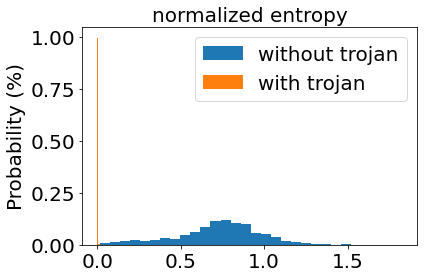

In [0]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

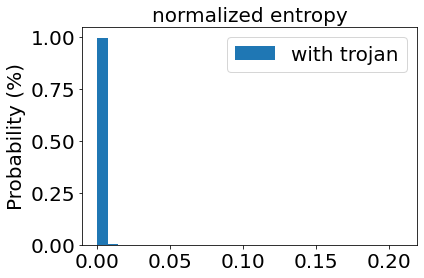

In [0]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

**CHECK INPUT DATA DISTRIBUTION**
Assumption: the input distribution is a normal distribution.
Defender can calculate the mean and standard deviation of the normal entropy distribution of the clean input.


In [0]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print("mu , sigma:", mu, sigma)

#FRR - False Rejection Rate , the probability when the clean input is regarded as a trojaned input.
#IDEALLY: Both FAR and FRR should be zero. But in reality, Detection system should minimise FAR while using a slighlty higher FRR as a tradeoff.
# If security concern is high then FRR >> 0.01  and decide which boundary suppress FAR.
threshold = scipy.stats.norm.ppf(0.1, loc = mu, scale =  sigma) #use a preset FRR=0.01. This can be 
print("Threshold:",threshold)

#FAR the probability that the trojaned input is recognised as the clean input. e.g. Is there a security concern?
FAR = sum(i > threshold for i in entropy_trojan)
print("False Acceptance Rate:",FAR/2000*100) #reproduce results in Table 3 of our paper

mu , sigma: 0.7266193980774879 0.2574351169434614
Threshold: 0.39670302093243764
False Acceptance Rate: 0.0


In [0]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print("Min Entropy of clean images", min_benign_entropy)# check min entropy of clean inputs
print("Max Entropy of trojaned images", max_trojan_entropy)# check max entropy of trojaned inputs

if (min_benign_entropy < max_trojan_entropy):
  print("Trojan detected")
else:
  print("Trojan NOT detected")

Min Entropy of clean images 0.014694104194641113
Max Entropy of trojaned images 0.20873704528808593
Trojan detected
